In [1]:
import sys
import os
sys.path.insert(0, os.path.join(os.getcwd(), '../../core'))
import kaggle_support as kgs
import importlib
import matplotlib.pyplot as plt
import numpy as np
import cupy as cp
from dataclasses import dataclass, field, fields
import pack_cuda
import pack_vis
import pack_cost
import copy
import time
from IPython.display import HTML, display, clear_output
pack_cuda.USE_FLOAT32 = True
pack_cuda._ensure_initialized()


CUDA_MPS_PIPE_DIRECTORY = /tmp/nvidia-mps
CUDA_MPS_LOG_DIRECTORY  = /tmp/nvidia-mps-log
mps-server running = False
local
init CUDA
Detected GPU compute capability: 8.9 (arch=sm_89)
GPU max threads per block: 1024
=== Compiling kernel variant: crystal ===
Defines: ENABLE_CRYSTAL_AXES, ENABLE_OVERLAP_AREA, ENABLE_SEPARATION
Command: /usr/local/cuda/bin/nvcc -O3 -use_fast_math --extra-device-vectorization --ptxas-options=-v,--warn-on-spills -arch=sm_89 -DENABLE_CRYSTAL_AXES -DENABLE_OVERLAP_AREA -DENABLE_SEPARATION -cubin /mnt/d//packing/temp/pack_cuda_saved.cu -o /mnt/d//packing/temp/pack_cuda_crystal.cubin
ptxas info    : 0 bytes gmem, 1172 bytes cmem[3]
ptxas info    : Compiling entry function 'multi_boundary_distance_list_total' for 'sm_89'
ptxas info    : Function properties for multi_boundary_distance_list_total
    0 bytes stack frame, 0 bytes spill stores, 0 bytes spill loads
ptxas info    : Used 36 registers, used 1 barriers, 404 bytes cmem[0], 16 bytes cmem[2]
ptxas info    : Co

In [2]:
%load_ext pyinstrument

In [3]:
#%%pyinstrument
#kgs.profiling=True
# %matplotlib widget
import pack_ga3
import pack_runner
fastMode = False
kgs.debugging_mode = 2 if fastMode else 1

runner_one_nTree = pack_ga3.baseline()
runner_one_nTree.ga.do_legalize = False
runner = copy.deepcopy(runner_one_nTree)

ga_list = []
N_trees_list = [30]
for N_tree in N_trees_list:
    ga_list.append( copy.deepcopy(runner_one_nTree.ga) )
    ga_list[-1].ga_base.N_trees_to_do = N_tree
    ga_list[-1].do_legalize= False
runner.ga = pack_ga3.GAMulti(single_champion=False)
runner.ga.ga_list = ga_list
runner.ga.make_own_fig = (1,1)
runner.ga.make_own_fig_size = (8,8)
runner.ga.best_costs_per_generation_ax = ((0,False,(0,0)),)
runner.diagnostic_plot = True
runner.plot_every = 3
runner.n_generations = 60000 if not fastMode else 3
runner.filename = f'ga_multi_tree_{np.min(N_trees_list)}_to_{np.max(N_trees_list)}'

runner.seed=84


KeyboardInterrupt: 

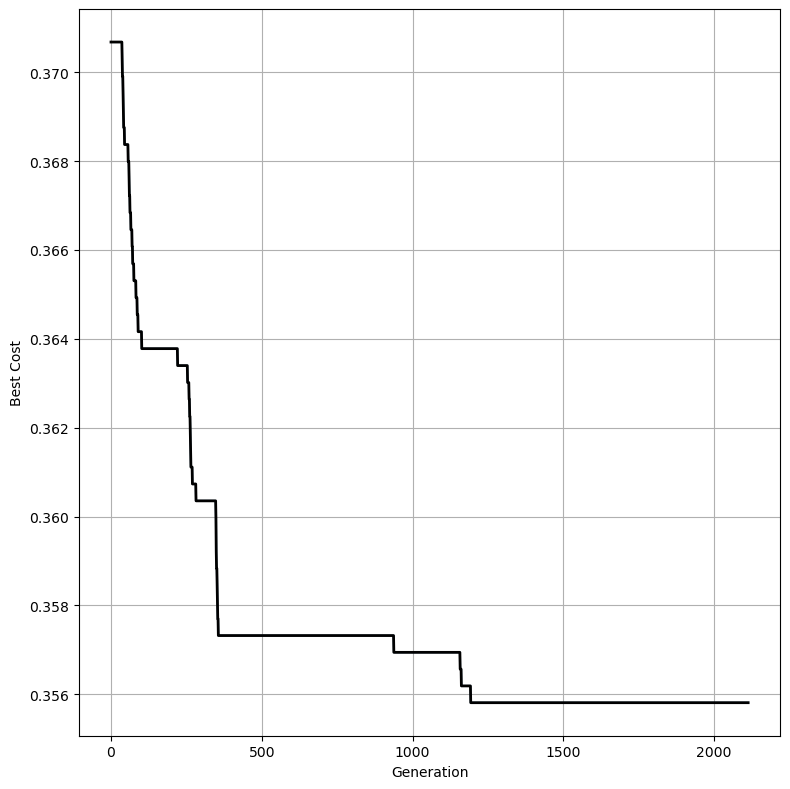

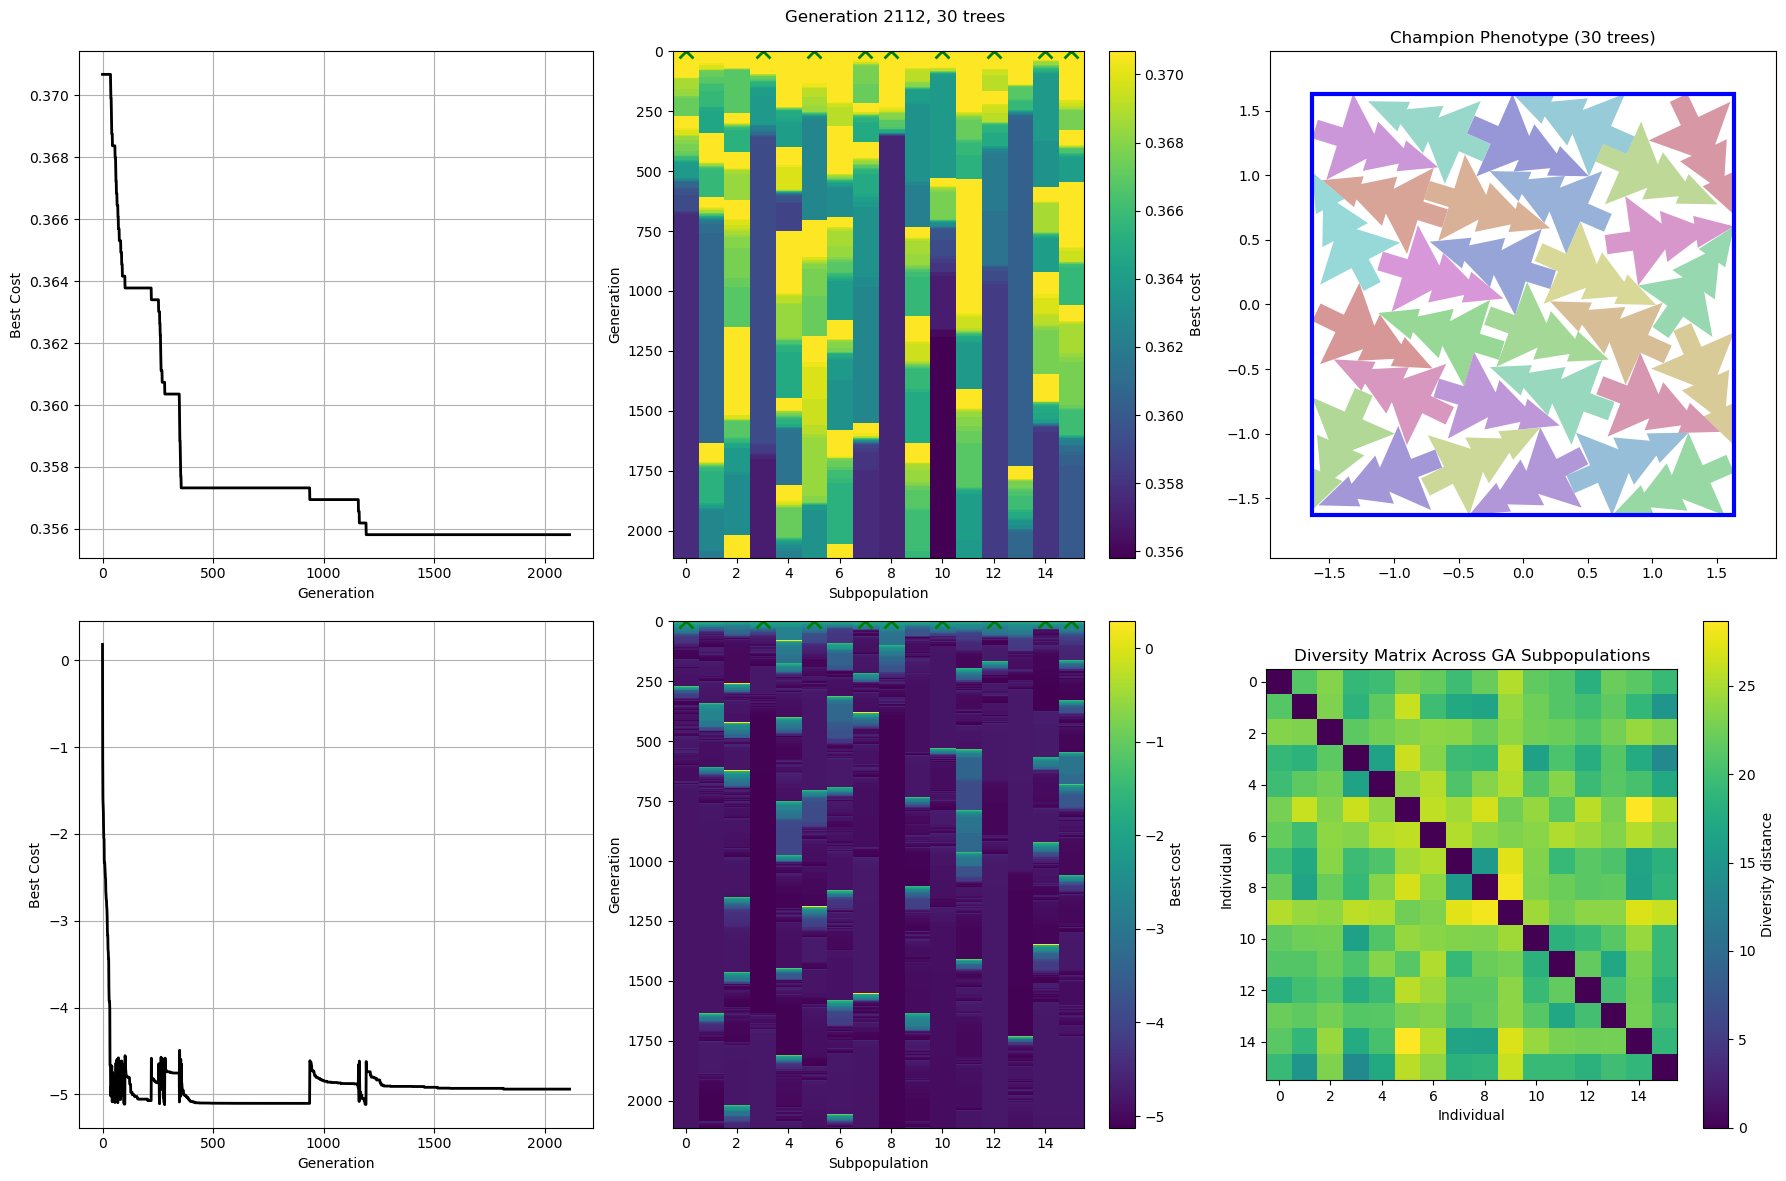

In [4]:
if os.path.isfile(kgs.temp_dir + runner.filename + '.pickle'):
    print("Loading existing runner...")
    runner = kgs.dill_load(kgs.temp_dir + runner.filename + '.pickle')
runner.run()

In [5]:
rr = kgs.dill_load(kgs.temp_dir + runner.filename + '.pickle')

N=30 best score: [3.5581282e-01 1.1538516e-05]
1


<Figure size 640x480 with 0 Axes>

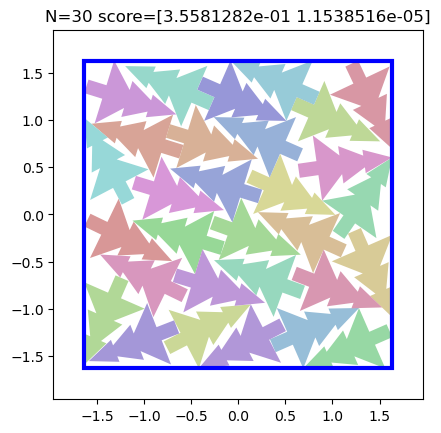

In [6]:
import pack_vis_sol
#rr.ga.diversity_reset_check_frequency = 1
#for ga in rr.ga.ga_list:
#    ga.diversity_reset_check_frequency = 1
#rr.ga.score(register_best=True) # remove duplicates
for ga in rr.ga.ga_list:
    best_score = ga.champions[-1].fitness[0]
    print(f"N={ga.ga_base.N_trees_to_do} best score: {best_score}")
    ga._fig = None
    ga._ax = None
    #ga.diagnostic_plots(-1,None)
    res = []
    for ga2 in ga.ga_list:        
        if ga2.champions[-1].fitness[0][0] == best_score[0]:
            plt.figure()
            pack_vis_sol.pack_vis_sol(ga2.champions[-1].phenotype)
            plt.title(f"N={ga.ga_base.N_trees_to_do} score={ga2.champions[-1].fitness[0]}")
            res.append(ga2.champions[-1].phenotype)
            print(ga2.champions[-1].phenotype.N_solutions)

In [7]:
# importlib.reload(kgs)
# rrr=copy.deepcopy(res[0])
# rrr.merge(res[1])
# div_matrix = kgs.compute_genetic_diversity_matrix(rrr.xyt, rrr.xyt)
# div_matrix

In [8]:
for ga in rr.ga.ga_list:
    ga.do_legalize = True
rr.ga.finalize()

Before optimization:  0.10675674676895142 1.290423642785754e-05 3.2671676
After optimization:  0.10610702633857727 0.000283856934402138 3.2530475
After optimization:  0.10639403760433197 9.48477245401591e-05 3.2603557
After optimization:  0.10668498277664185 1.9840997993014753e-05 3.265963
After optimization:  0.10682472586631775 5.663259798893705e-06 3.2683187
After optimization:  0.10690487176179886 1.6411731849075295e-06 3.269606
After optimization:  0.10695397108793259 4.982643986295443e-07 3.2703743
After optimization:  0.10698586702346802 1.1512907605037981e-07 3.2708676
After optimization:  0.1069955825805664 5.974582961698616e-08 3.271017
After optimization:  0.10700377821922302 3.483099320078509e-08 3.2711427
After optimization:  0.10700716823339462 2.016044220454205e-08 3.2711947
After optimization:  0.10701307654380798 8.258544070827156e-09 3.2712853
After optimization:  0.10702010989189148 7.699777482272907e-10 3.2713928
After optimization:  0.10702060163021088 3.5074063098

In [9]:
# import pack_io
# sol_list = [ga.champions[-1].phenotype for ga in rr.ga.ga_list]
# df = pack_io.solution_list_to_dataframe(sol_list)

In [10]:
sol_list = [ga.champions[-1].phenotype for ga in rr.ga.ga_list]
kgs.dill_save(kgs.code_dir + f'../res/' + runner.filename + '.pickle', sol_list)

In [ ]:
print(kgs.code_dir + f'../res/' + runner.filename + '.pickle')

/mnt/d//packing/code/core/../res/ga_multi_tree_40_to_40.pickle
